This notebook shows the plotting process for Figure 2, where we present the relationship between the scientist's exploration metrics and performance. Before drawing, we first pre-process the data in each section. <br>
In the [draw subgraph(a)](#draw-subgraph(a)) section, we calculate the EP and citation per paper for each scientist's entire career and plot the **subplot (a) of Figure 2** in the main text.<br>
In the [draw subgraph(b)](#draw-subgraph(b)) section, for each paper a scientist publishes, we compute her past performance and figure out whether this paper is exploratory, and then draw **subplot (b) of Figure 2**.<br>
In the [draw subgraph(c)](#draw-subgraph(c)) section, we control for the scientists' past performance and compute their past EP and future performance, and then graph **Figure 2(c)**.<br>
In the [draw subgraph(d)-(f)](#draw-subgraph(d)-(f)) section, we use Stata to obtain the marginal effects of EP and ED on future performance and draw **Figure 2(d)-(f)**.<br>

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import scipy
import tqdm as tq
import pickle


def save_pkl(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)


def load_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [2]:
figsize = (5, 5)
fontsize = figsize[0]*3 + 3
font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}
plt.rc('font', **font_conf)
colors = ['steelblue', (0.9019607843137255, 0.0, 0.0, 1.0)]

# load data

In [3]:
def load_data():
    DATA_path = '../data/processing_data/'
    distance_info = pd.read_pickle(DATA_path+"avg_switch_distance_info.pkl")
    author_paper = pd.read_pickle(DATA_path+"author_paper.pkl")

    numbers = []
    for aid, presonal_info in distance_info.groupby(by='aid'):
        for i in range(2, len(presonal_info)+2):
            numbers.append(i)
    distance_info['attempt_number'] = numbers
    # distance_info = distance_info[distance_info['attempt_number']>=10]

    # authors with more than 10 papers
    author_paper = author_paper.loc[author_paper['paperCount'] >= 10]
    all_author = set(author_paper['aid'].unique().tolist())
    distance_info = distance_info.loc[distance_info['aid'].isin(all_author)]

    return author_paper, distance_info

# draw subgraph(a)
First, we calculate the EP and $\log c_5$ per paper for each scientist's entire career and divide the scientists into groups by aligning their EPs to the nearest integer multiples of 0.1.

Then, we can draw Figure 2(a).

In [4]:
author_paper, distance_info = load_data()

In [5]:
# process data
author_paper = author_paper.groupby(['aid']).logCit.mean()
author_paper = author_paper.reset_index()
distance_info2 = distance_info.groupby(['aid']).mean().reset_index()
info = distance_info2.merge(author_paper, on=['aid'])

In [6]:
out = info[['aid', 'N5_es', 'N5_es_distance', 'logCit']]
out.columns = ['aid', 'EP', 'ED', 'logCit']
out.to_csv('../data/fig2/aps_overall.csv', index=False)

In [7]:
aps_data = pd.read_csv('../data/fig2/aps_overall.csv')

In [8]:
label = 'EP'
print(
    f"Correlaiton between {label} and logc5 in aps is {round( float( aps_data.corr()[label] ['logCit'] )  ,5)}")

Correlaiton between EP and logc5 in aps is -0.10694


In [9]:
# draw
aps_data['cut'] = (pd.cut(aps_data[label], bins=10, right=True))

data1 = (aps_data.groupby(['cut']).agg(
    {'aid': 'count', 'logCit': 'std'}).reset_index())
data1_95 = list(1.96 * data1['logCit'] / (data1['aid'].apply(np.sqrt)))
data1 = (aps_data.groupby(['cut']).agg({'logCit': 'mean'}).reset_index())
data1_performance = list(data1['logCit'])

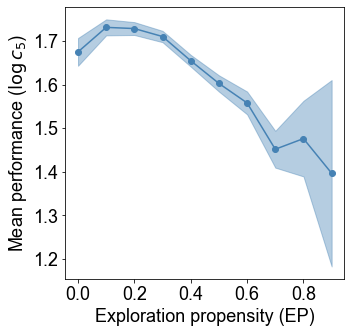

In [10]:
x_labels = np.arange(0, 1, .1)
n_step = .1

fig, ax1 = plt.subplots(figsize=figsize)
ax1.plot(x_labels, data1_performance, '-o', color=colors[0])
ax1.fill_between(x_labels, data1_performance - np.array(data1_95),
                 data1_performance + np.array(data1_95), alpha=0.4, color=colors[0])

font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}
ax1.set_ylabel('Mean performance ($\log c_5$)', fontdict=font_conf)
ax1.set_xlabel('Exploration propensity (EP)', fontdict=font_conf)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax1.grid(False)
plt.savefig('./draw/figure_2a.png', format="png", bbox_inches="tight")
plt.show()

# draw subgraph(b)
First, we calculate each author's past academic performance at the time of each paper and whether the current paper is exploratory. 

Then, we plot Figure 2(b) based on the results of the calculation.

In [11]:
author_paper, distance_info = load_data()

result = []
for i, g in tq.tqdm(author_paper.groupby(['aid'])):
    for k in range(1, g.shape[0]):
        result.append([i, k+1, float(g.head(k).logCit.mean()), float(
            g.head(k).tail(1).logCit.mean()),  float(g.head(k).tail(5).logCit.mean())])

100%|██████████| 25237/25237 [05:09<00:00, 81.44it/s] 


In [12]:
result = pd.DataFrame(result)
result.columns = ['aid', 'attempt_number', 'pastmeanlogcitation',
                  'pastmeanlogcitation1', 'pastmeanlogcitation5']

distance_info['lastDate'] = pd.to_datetime(distance_info['lastDate'])
distance_info['thisDate'] = pd.to_datetime(distance_info['thisDate'])
distance_info['firstyear'] = distance_info.aid.map(
    distance_info.groupby(['aid']).lastDate.min().to_dict())
distance_info["CareerYear"] = (
    distance_info["thisDate"]-distance_info["firstyear"]).dt.days//365 + 1

result = distance_info[['aid', 'N5_es', 'attempt_number', 'CareerYear']].merge(
    result, on=['aid', 'attempt_number'])

t = result[['aid', 'N5_es', 'attempt_number', 'pastmeanlogcitation']]
t.columns = ['aid', 'EP', 'attempt_number', 'pastmeanlogcitation']
t.to_csv('../data/fig2/aps_attempts.csv', index=False)

In [13]:
aps_data = pd.read_csv('../data/fig2/aps_attempts.csv')

In [14]:
left = aps_data['pastmeanlogcitation'].quantile(0)
right = aps_data['pastmeanlogcitation'].quantile(0.995)  # 0.995
step = (right-left)/(20-1)
x_labels = np.arange(left, right, step)
aps_data['cut'] = (pd.cut(aps_data['pastmeanlogcitation'],
                   bins=list(np.arange(left, right, step)), right=False))

data1 = (aps_data.groupby(['cut']).agg(
    {'aid': 'count', 'EP': 'std'}).reset_index())
data1_95 = list(1.96 * data1['EP'] / (data1['aid'].apply(np.sqrt)))
data1_count = list(data1['aid'])
data1 = (aps_data.groupby(['cut']).agg({'EP': 'mean'}).reset_index())
data1_performance = list(data1['EP'])

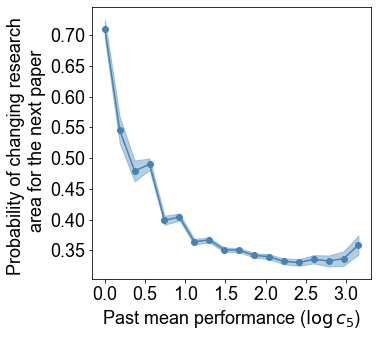

In [15]:
fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.plot(x_labels[:-1], data1_performance, '-o', color=colors[0])
ax1.fill_between(x_labels[:-1], data1_performance - np.array(data1_95),
                 data1_performance + np.array(data1_95), alpha=0.4, color=colors[0])
font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}
ax1.set_ylabel(
    'Probability of changing research \n area for the next paper', fontdict=font_conf)
ax1.set_xlabel('Past mean performance ($\log c_5$)', fontdict=font_conf)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax1.grid(False)
plt.savefig('./draw/figure_2b.png', format="png", bbox_inches="tight")
plt.show()

# draw subgraph(c)
First, when considering 10 career year as split point, we control for past performance and calculate the mean value of future performance under different past EPs.

Then, we can plot Figure 2(c).

In [16]:
def draw_c(label, person_data):
    person_data['cut'] = (pd.cut(person_data[label], bins=10, right=False))

    data1 = (person_data.groupby(['cut']).agg(
        {'aid': 'count', 'post_logCit': 'std'}).reset_index())
    data1_95 = list(1.96 * data1['post_logCit'] /
                    (data1['aid'].apply(np.sqrt)))
    data1 = (person_data.groupby(['cut']).agg(
        {'post_logCit': 'mean'}).reset_index())
    data1_performance = list(data1['post_logCit'])
    x_labels = np.arange(0, 1, .1)
    n_step = .1

    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(x_labels, data1_performance, '-o', color=colors[0])
    ax1.fill_between(x_labels, data1_performance - np.array(data1_95),
                     data1_performance + np.array(data1_95), alpha=0.4, color=colors[0])

    ax1.set_ylabel('Mean future performance ($\log c_5$)', fontdict=font_conf)
    ax1.set_xlabel('Past exploration propensity (EP)', fontdict=font_conf)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylim(min(data1_performance - np.array(data1_95))-.25,
             max(data1_performance + np.array(data1_95))+.25)
    ax1.grid(False)
    plt.savefig('./draw/figure_2c.png', format="png", bbox_inches="tight")
    plt.show()

In [17]:
year_split = pd.read_csv(
    '../data/regression/split_career/cyear_10_author_info.csv')
year_split

,aid,past_paperCount,first_year,first_genre,past_logCit,post_logCit,post_paperCount,post_career,whole_count,past_es,past_es_dis
0,36,4,1988,"[31, 31, 32]",0.447940,1.681995,27,12,31,0.333333,0.678418
1,37,19,2004,"[61, 71, 73, 71]",2.278066,3.204861,5,1,24,0.722222,0.629122
2,40,2,1989,[25],1.647918,2.303875,15,5,17,0.000000,0.727827
3,45,4,1995,"[52, 52]",1.657010,1.563793,17,8,21,0.666667,0.793907
4,49,11,1993,"[64, 5, 68]",1.861636,1.866633,55,12,66,0.400000,0.588959
...,...,...,...,...,...,...,...,...,...,...,...
18162,2139982,2,2000,[4],1.666102,1.188918,14,4,16,0.000000,0.128076
18163,2144117,12,2002,"[11, 11, 11]",1.269248,0.693147,2,1,14,0.181818,0.237011
18164,2144212,10,1998,"[13, 12, 14, 14]",1.908383,1.926316,4,2,14,0.111111,0.304875
18165,2156199,7,1996,"[14, 96, 97]",1.831082,1.521449,3,5,10,0.666667,0.562872


In [18]:
# get different quantiles of the authors' performance
quantiles = [np.percentile(year_split.past_logCit, 10*i) for i in range(0, 11)]
quantiles

[0.0,
 0.8958797346140277,
 1.1337324605540515,
 1.2999252141620083,
 1.4460362190053864,
 1.5850741607377534,
 1.7301265218693458,
 1.885393931165639,
 2.0720943140621695,
 2.33958371684682,
 4.264155320098482]

In [19]:
quantiles = [np.percentile(year_split.past_logCit, 10*i) for i in range(0, 11)]
quantiles
group = []
for i in range(10):
    group.append(year_split[(year_split.past_logCit >= quantiles[i]) & (
        year_split.past_logCit < quantiles[i+1])])

In [20]:
group[6][['aid', 'past_logCit', 'past_es', 'post_logCit']].reset_index(
    drop=True).to_csv('../data/fig2/pastes_futurecit.csv', index=False)

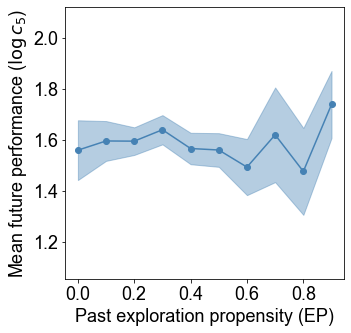

In [21]:
draw_c('past_es', pd.read_csv('../data/fig2/pastes_futurecit.csv'))

# draw subgraph(d)-(f)
First, we use the Stata code to obtain the marginal effects of EP and ED at different split points.

Then, Figure 2(d)-(f) is plotted based on the Stata results.

In [22]:
# Run the following code with Stata to obtain the corresponding margin effect
'''
cd ../data/regression/split_career/
//year
clear
insheet using stata_10_year.csv

cd ../../fig2

reg post_logcit past_logcit past_es past_papercount i.first_year genre_* if (past_papercount>=5 & post_papercount>=3)
//margin
margins, at( past_es=(0(0.05)1))  post
//out
parmest, label format(p %8.2f) stars(0.1 0.05 0.01) ///
list(parm label estimate min95 max95 p stars, clean noobs)
parmest, saving("10yearonlyep.dta", replace) format(parm %20s ///
estimate %8.3f std %8.3f t %8.3f min95 %8.3f max95 %8.3f p %8.2f)


reg post_logcit past_logcit past_es past_es_dis past_papercount i.first_year genre_* if (past_papercount>=5 & post_papercount>=3)
margins, at( past_es_dis=(0(0.05)1)) post 

parmest, label format(p %8.2f) stars(0.1 0.05 0.01) ///
list(parm label estimate min95 max95 p stars, clean noobs)
parmest, saving("10yeared.dta", replace) format(parm %20s ///
estimate %8.3f std %8.3f t %8.3f min95 %8.3f max95 %8.3f p %8.2f)


reg post_logcit past_logcit past_es past_es_dis past_papercount i.first_year genre_* if (past_papercount>=5 & post_papercount>=3)
margins, at( past_es=(0(0.05)1))  post
parmest, label format(p %8.2f) stars(0.1 0.05 0.01) ///
list(parm label estimate min95 max95 p stars, clean noobs)
parmest, saving("10yearep.dta", replace) format(parm %20s ///
estimate %8.3f std %8.3f t %8.3f min95 %8.3f max95 %8.3f p %8.2f)

'''

'\ncd ../data/regression/split_career/\n//year\nclear\ninsheet using stata_10_year.csv\n\ncd ../../fig2\n\nreg post_logcit past_logcit past_es past_papercount i.first_year genre_* if (past_papercount>=5 & post_papercount>=3)\n//margin\nmargins, at( past_es=(0(0.05)1))  post\n//out\nparmest, label format(p %8.2f) stars(0.1 0.05 0.01) ///\nlist(parm label estimate min95 max95 p stars, clean noobs)\nparmest, saving("10yearonlyep.dta", replace) format(parm %20s ///\nestimate %8.3f std %8.3f t %8.3f min95 %8.3f max95 %8.3f p %8.2f)\n\n\nreg post_logcit past_logcit past_es past_es_dis past_papercount i.first_year genre_* if (past_papercount>=5 & post_papercount>=3)\nmargins, at( past_es_dis=(0(0.05)1)) post \n\nparmest, label format(p %8.2f) stars(0.1 0.05 0.01) ///\nlist(parm label estimate min95 max95 p stars, clean noobs)\nparmest, saving("10yeared.dta", replace) format(parm %20s ///\nestimate %8.3f std %8.3f t %8.3f min95 %8.3f max95 %8.3f p %8.2f)\n\n\nreg post_logcit past_logcit past_e

In [23]:
def draw_margins(result, label, text, save_path):
    if (label == 'EP'):
        color = colors[0]
    if (label == 'ED'):
        color = colors[0]

    x_label = list(np.arange(0, 1.05, .05))
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(x_label, result['estimate'], label=text,  marker='o', color=color)
    ax1.fill_between(x_label, list(result['min95']), list(
        result['max95']), alpha=0.4, color=color)

    ax1.set_ylabel('Predictive margins', fontdict=font_conf)

    if (label == 'EP'):
        ax1.set_xlabel('Past exploration propensity (EP)', fontdict=font_conf)
        plt.text(0.05, 0.8, text, fontsize=fontsize, transform=ax1.transAxes)
    if (label == 'ED'):
        ax1.set_xlabel('Past exploration distance (ED)', fontdict=font_conf)
        plt.text(0.25, 0.8, text, fontsize=fontsize, transform=ax1.transAxes)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    ax1.grid(False)

    plt.savefig(save_path, format="png", bbox_inches="tight")
    plt.show()

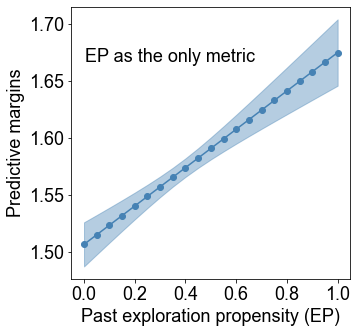

In [24]:
result = pd.read_stata('../data/fig2/10yearonlyep.dta')
draw_margins(result, 'EP', 'EP as the only metric', './draw/figure_2d.png')

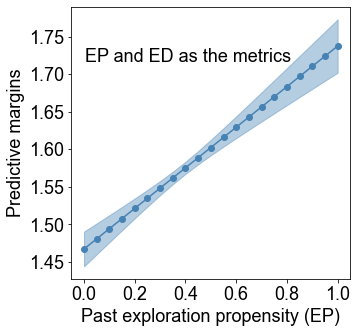

In [25]:
result = pd.read_stata('../data/fig2/10yearep.dta')
draw_margins(result, 'EP', 'EP and ED as the metrics', './draw/figure_2e.png')

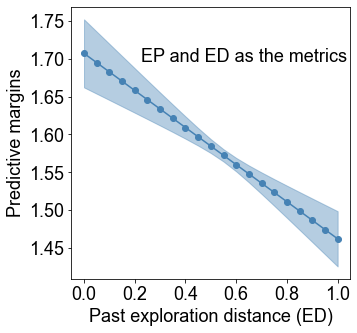

In [26]:
result = pd.read_stata('../data/fig2/10yeared.dta')
draw_margins(result, 'ED', 'EP and ED as the metrics', './draw/figure_2f.png')